## <font color=pink>피드백</font>

<font color=pink>
1. EDA에서 분석하신 결과에 대한 정하님만의 해석이 더 있었다면 좋았을 것 같습니다.<br>
2. 별점을 가중치로 빈도에 반영해 단어구름을 만드는 것 또한 의미있는 EDA일 것 같습니다.(예를 들면 판매자의 입장에서 좋은 점보다 개선해야할 점이 중요할 수 있으니, 낮은 별점에 높은 가중치를 부여한다든가처럼요!).<br>
</font>

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm 
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name())
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from wordcloud import WordCloud
from selenium.webdriver import Chrome
from kiwipiepy import Kiwi
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot
from factor_analyzer.rotator import Rotator
import lxml.html
import requests
import re
import os
import stanza
import joblib
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from gensim.models import CoherenceModel
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

C:\Users\gimje\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
browser = Chrome()
url = 'http://department.ssg.com/item/itemView.ssg?itemId=0000000158137&siteNo=6009&salestrNo=1004'

browser.get(url)
time.sleep(2)

# 고객 리뷰 클릭
review_page = browser.find_elements_by_css_selector('#_cdtl_dtlcont_wrap > div.cdtl_dtlcont_lft > div > div.cdtl_tab_fixed > ul > li:nth-child(2) > a')
review_page[0].click()

# for문 범위 지정을 위한 총 리뷰 개수 추출
last = browser.find_elements_by_css_selector('#cdtl_cmt_tbody > tr:nth-child(1) > td.number > div')
last_page = last[0].text
page_10 = int(last_page)//100
page_end = int(last_page)%10
page_last = int(last_page)%100//10 if page_end == 0 else int(last_page)%100//10 + 1


dior_re = []
dior_st = []

# 리뷰 및 별점 스크래핑 함수
def review_star() :
    for review in browser.find_elements_by_css_selector('a.clickable div.cdtl_cmt_tx.v2 span.desc'):
        dior_re.append(review.text)
    time.sleep(1)
    for star in browser.find_elements_by_css_selector('td.star div.in span.sp_cdtl.cdtl_cmt_star span.sp_cdtl.cdtl_cmt_per'):
        dior_st.append(star.text)
    time.sleep(1)
            
# 다음 페이지로 넘기는 함수        
def next_page() :
    url = f'#comment_navi_area > a:nth-child({i})'
    next_page = browser.find_elements_by_css_selector(url)
    next_page[0].click()
    time.sleep(2)
    
    
    
## 웹스크래핑

review_star()  # 첫페이지 웹스크래핑

i = 2          
next_page()    # 두번째 페이지 웹스크래핑 

for i in range(4,13) :        # 3~10p 스크래핑
    review_star()
    next_page()
    
for j in range(page_10 -1) :  # 10 페이지 단위로 스크래핑 
    for i in range(4,14) :
        review_star()
        next_page()

In [7]:
dior_review = pd.DataFrame(dior_re , columns = ['review'])
dior_star = pd.DataFrame(dior_st , columns = ['star'])
dior_content = pd.concat([dior_review , dior_star], axis = 1)


dior_content['point'] = dior_content['star'].apply(lambda x : int(x[-2]))
del dior_content['star']

dior_content.to_csv('dior.csv' ,index = False)

In [3]:
dior = pd.read_csv('dior.csv')

In [4]:
dior

,review,point
0,사실 디올인데 무슨말이 더 필요있나요~ 저는 선물포장 신청해서 선물포장 된채로 배송...,5
1,안녕하세요 ㅎㅎ 코로나로 인해 사용하던 립스틱이 마스크에 직업특성상 마스크를 착용한...,5
2,아는분 생일선물로 구입했어요 귀띰없이 배송시켰더니 자기 선물 맞냐고 연락왔어요 ㅎㅎ...,5
3,디올 공식 사이트 구입이 안돼서 여기서 구입하는데 매장 가기에는 코로나 때문에 그냥...,4
4,워낙 유명한제품이라 알고는있었는데..처음구입해봤어요!! 평소에립스틱제품을사도.한두번...,5
...,...,...
11995,좋아요,5
11996,만족~,5
11997,상품 괜찮네요~~,5
11998,좋아요~^^,5


- 전처리

In [5]:
def clean_text(texts): 
    review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts)) 
    review = review.lower() 
    review = re.sub(r'\s+', ' ', review) 
    review = re.sub(r'<[^>]+>','',review) 
    review = re.sub(r'\s+', ' ', review) 
    review = re.sub(r"^\s+", '', review) 
    review = re.sub(r'\s+$', '', review) 
    return review

def no_emoji(text) :
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [6]:
dior['review'] = dior['review'].apply(clean_text)
dior['review'] = dior['review'].apply(no_emoji)

In [7]:
dior_5 = dior.query('point == 5 ')
dior_4 = dior.query('point == 4 ')
dior_3 = dior.query('point == 3 ')
dior_2 = dior.query('point == 2 ')
dior_1 = dior.query('point == 1 ')

In [8]:
# 단어빈도행렬 만들기
nlp = stanza.Pipeline('ko')

def extract_nouns(text):
    doc = nlp(text)
    for sentence in doc.sentences:
        for word in sentence.words:
            lemma = word.lemma.split('+')
            xpos = word.xpos.split('+')
            for lem, pos in zip(lemma, xpos):
                if pos.startswith('n') :
                    yield lem

2021-07-07 23:13:55 INFO: Loading these models for language: ko (Korean):
| Processor | Package |
-----------------------
| tokenize  | kaist   |
| pos       | kaist   |
| lemma     | kaist   |
| depparse  | kaist   |

2021-07-07 23:13:55 INFO: Use device: gpu
2021-07-07 23:13:55 INFO: Loading: tokenize
2021-07-07 23:13:56 INFO: Loading: pos
2021-07-07 23:13:57 INFO: Loading: lemma
2021-07-07 23:13:57 INFO: Loading: depparse
2021-07-07 23:13:57 INFO: Done loading processors!


In [14]:
cv = CountVectorizer(max_features=100 , tokenizer=extract_nouns)
tdm5 = cv.fit_transform(dior_5['review'])

word_count5 = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm5.sum(axis=0).flat
}).sort_values('빈도', ascending=False)

words5 = cv.get_feature_names()
count_dic5 = word_count5.set_index('단어')['빈도'].to_dict()

In [13]:
cv = CountVectorizer(max_features=100 , tokenizer=extract_nouns)
tdm4 = cv.fit_transform(dior_4['review'])

word_count4 = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm4.sum(axis=0).flat
}).sort_values('빈도', ascending=False)

words4 = cv.get_feature_names()
count_dic4 = word_count4.set_index('단어')['빈도'].to_dict()

In [11]:
cv = CountVectorizer(max_features=100 , tokenizer=extract_nouns)
tdm3 = cv.fit_transform(dior_3['review'])

word_count3 = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm3.sum(axis=0).flat
}).sort_values('빈도', ascending=False)

words3 = cv.get_feature_names()
count_dic3 = word_count3.set_index('단어')['빈도'].to_dict()

In [10]:
cv = CountVectorizer(max_features=100 , tokenizer=extract_nouns)
tdm2 = cv.fit_transform(dior_2['review'])

word_count2 = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm2.sum(axis=0).flat
}).sort_values('빈도', ascending=False)

words2 = cv.get_feature_names()
count_dic2 = word_count2.set_index('단어')['빈도'].to_dict()

In [9]:
cv = CountVectorizer(max_features=100 , tokenizer=extract_nouns)
tdm1 = cv.fit_transform(dior_1['review'])

word_count1 = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm1.sum(axis=0).flat
}).sort_values('빈도', ascending=False)

words1 = cv.get_feature_names()
count_dic1 = word_count1.set_index('단어')['빈도'].to_dict()

### EDA

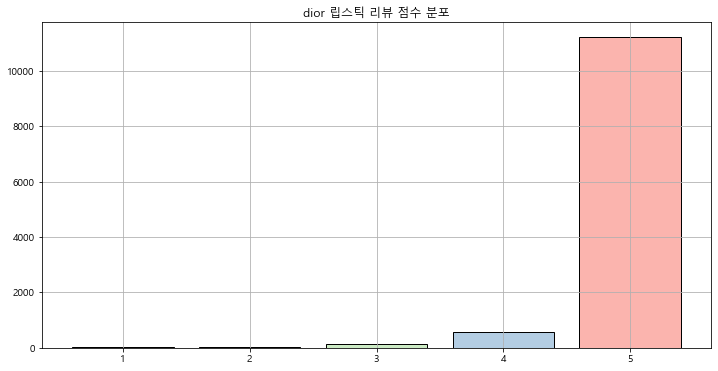

In [25]:
fig, axes = plt.subplots(1,1, figsize=(12,6))

colors = cm.get_cmap('Pastel1')(np.arange(5))

a = dior.point.value_counts()

plt.bar(a.index ,                      
        a  ,       
        color = colors ,               
        edgecolor = 'black' ,          
        linewidth = 1 ,                 
       ) 
plt.grid(True)
plt.title('dior 립스틱 리뷰 점수 분포')
plt.show()

- 리뷰 점수별 단어 구름

In [15]:
from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)

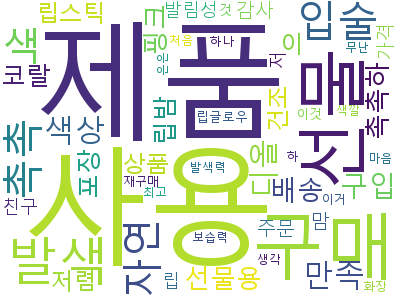

In [16]:
# 별점 5점 리뷰 단어구름 

cloud = wc.generate_from_frequencies(count_dic5)
cloud.to_image()

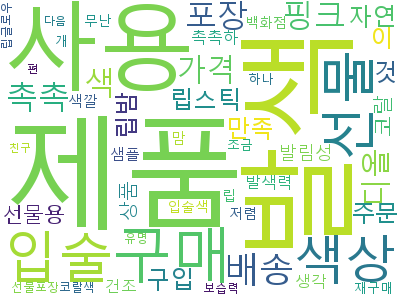

In [17]:
# 별점 4점 리뷰 단어구름 

cloud = wc.generate_from_frequencies(count_dic4)
cloud.to_image()

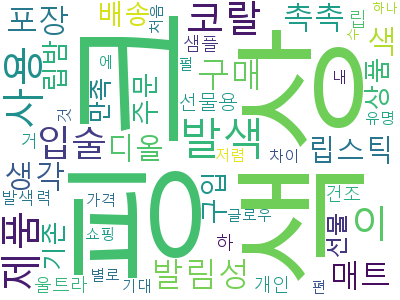

In [18]:
# 별점 3점 리뷰 단어구름 

cloud = wc.generate_from_frequencies(count_dic3)
cloud.to_image()

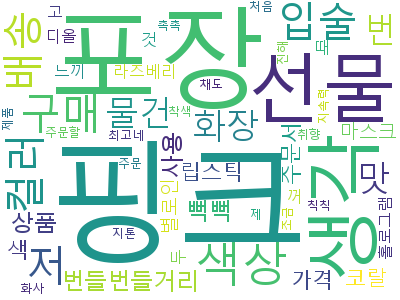

In [19]:
# 별점 2점 리뷰 단어구름 

cloud = wc.generate_from_frequencies(count_dic2)
cloud.to_image()

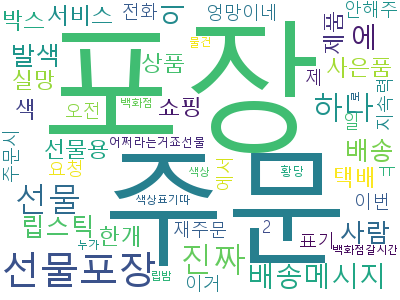

In [20]:
# 별점 1점 리뷰 단어구름 

cloud = wc.generate_from_frequencies(count_dic1)
cloud.to_image()